In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
#import rasterio

In [14]:
from aux_func import search_names

In [15]:
names = search_names('data', '.tif')

In [45]:
# with rasterio open tif transfor to numpy
def read_tif(file):
    with rasterio.open(file) as src:
        data = src.read()
        return data

otra opción

In [53]:
names_np = search_names('data', '.npy')

In [56]:
images = [x for x in names_np if 'image' in x]
masks = [x for x in names_np if 'mask' in x]

Img shape:  (2722, 5282, 4)


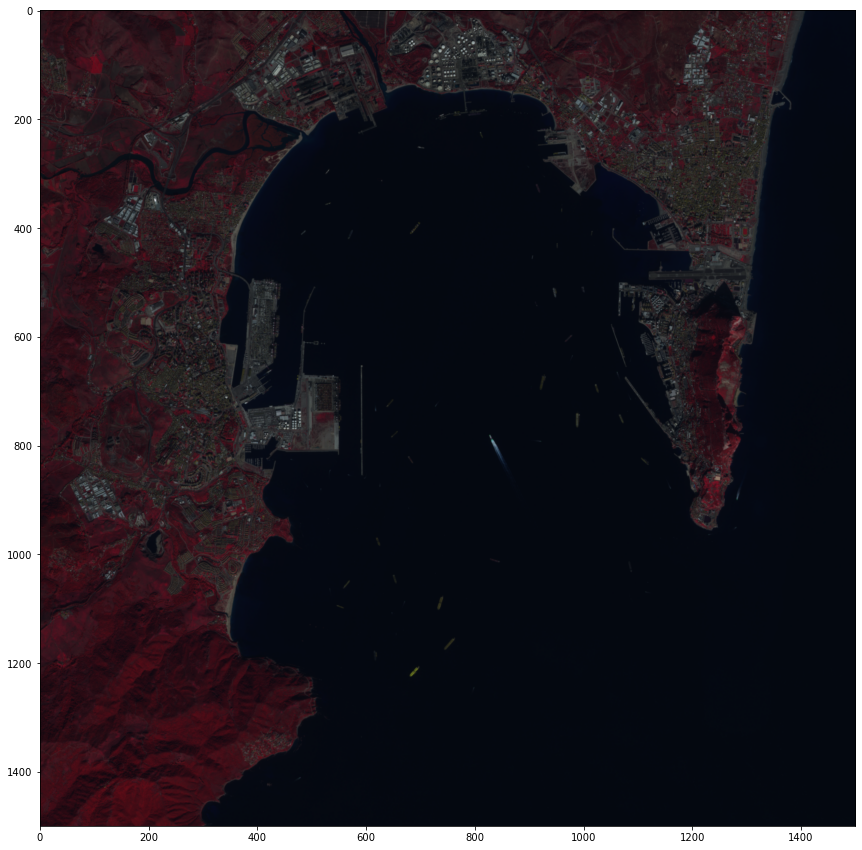

In [78]:
# Plottin img
image = np.load(images[2])
print('Img shape: ', image.shape)
image_cut = image[1000:2500,2000:3500][...,3:0:-1]
plt.figure(figsize=(15,15))
plt.imshow(image_cut)
plt.show()

Mask shape:  (2722, 5282, 1)


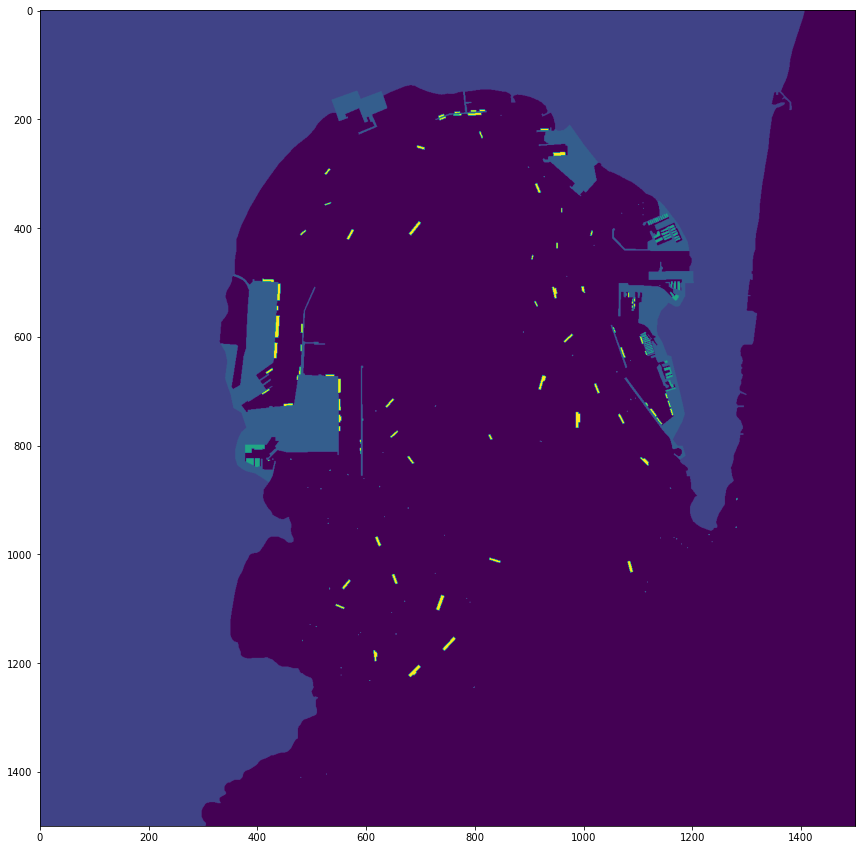

In [79]:
# Plottin img
image = np.load(masks[2])
print('Mask shape: ', image.shape)
image_cut = image[1000:2500,2000:3500]
plt.figure(figsize=(15,15))
plt.imshow(image_cut)
plt.show()

In [70]:
# data split
Xtrain_names = [x for x in images if 'train' in x]
Xtest_names = [x for x in images if 'test' in x]
ytrain_names = [x for x in masks if 'train' in x]
ytest_names = [x for x in masks if 'test' in x]

Xtrain = np.stack([np.load(x) for x in Xtrain_names])
Xtest = np.stack([np.load(x) for x in Xtest_names])
ytrain = np.stack([np.load(x) for x in ytrain_names])
ytest = np.stack([np.load(x) for x in ytest_names])

print('Shapes: ', Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

Shapes:  (7, 2722, 5282, 4) (3, 2722, 5282, 4) (7, 2722, 5282, 1) (3, 2722, 5282, 1)


In [71]:
# reduce 
Xtrain = Xtrain[:,1100:2300,2300:3300]
ytrain = ytrain[:,1100:2300,2300:3300]
Xtest = Xtest[:,1100:2300,2300:3300]
ytest = ytest[:,1100:2300,2300:3300]

In [72]:
# changing labels
y_train = np.where(np.isin(ytrain, [8,9,10]), 1, 0)
y_test = np.where(np.isin(ytest, [8,9,10]), 1, 0)

capas HSV

In [81]:
import cv2


In [86]:
train_ds = tf.data.Dataset.from_tensor_slices((Xtrain, y_train))
validation_ds = tf.data.Dataset.from_tensor_slices((Xtest, y_test))

In [87]:
#Create function for data augmentation
def data_aug(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    return image, label

In [100]:
def cut_data(image, label):
    """
    Generate a random crop of the image and label.
    :param image: image to crop
    :type image: numpy.ndarray
    :param label: mask to crop
    :return:
    :rtype: np.ndarray
    """
    image_label = tf.concat([image, label], axis=-1)
    image_label = tf.image.random_crop(image_label, (64,64,5))
    image = image_label[...,:4]
    label = image_label[...,4:]
    return image, label

In [98]:
# process data
def data_processing(data,shuffle=False,data_aug=False, batch_size=15):
    if shuffle:
        data = data.shuffle(10)
    data = data.map(cut_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if data_aug:
        data = data.map(data_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    data = data.batch(batch_size)
    return data

In [ ]:
data_processing(train_ds, shuffle=True, data_aug=True)

In [ ]:
# Build a neural network to detect the presence of a boat
def boat_detector(Xtrain, ytrain):
    